###  <span style="font-family: Calibri; font-size:2.0em;color:#000055"> FIT5196-S2-2020 Assessment 3 </span>
###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Author: Hitanshu Jain </span>
###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Student ID: 31337406 </span>
###  <span style="font-family: Calibri; font-size:1.5em;color:#000055"> Introduction </span>
The .zip files contains various datasets from the purpose of developing an linear model to predict various attributes related to properties located in Victoria, Australia. 
specification to know about :

- Defualts values has been provided for various attributes in the event of NAN value

- Harvesine distance have been used in kilometers all across the project.  

- Only trip departed on weekdays (Monday - Friday) between 07:00 - 09:00 has been considered

- Transfer flag of `0` means direct trip to flinders street station. Transfer flag of `1` means indirect trip

In [1]:
#------------------------------------------ Importing required libraries --------------------------------------------------
import os
from zipfile import ZipFile 
from distutils.dir_util import copy_tree
import pandas as pd
import numpy as np

import json   #-------------------------------------------- Opening json ----------------------------
import xlrd
import geopandas as gpd #---------------------------------- Opening Shapefile -----------------------
#%pip install shapely
import shapely
from shapely.geometry import Point
from shapely.geometry import shape
from shapely.geometry import Polygon
import xml.etree.ElementTree as ET

#%pip install tabula-py
import tabula  #-------------------------------------------- Opening pdf ----------------------------

from math import sin, cos, sqrt, atan2, radians  #---------- for Harvesine distance -----------------

import warnings #------------------------------------------- supressing warnings --------------------
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt  #-------------------------- For Plotting ---------------------------
import seaborn as sns

import statsmodels.formula.api as sm  #--------------------- For Linear Modelling -------------------
from sklearn import preprocessing

###  <span style="font-family: Calibri; font-size:1.5em;color:#000055"> Task1 : Data Integration </span>
In Real life even if an company manage to extract important data, changes are it will come from different sources . Data might even be in various formats such as .csv, .json, .txt, etc. The Company needs to combine data from different sources for operational actions or analytical needs. Data integration is not a small task for data engineers if the big data is used. 

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Importing Data </span>

In [2]:
def zip_extract(file_name):
    #---------------------------------------- opening the zip file ---------------------------------
    with ZipFile(file_name, 'r') as zip: 
        #----------------------- extracting all the contents of the zip file ------------------------
        zip.extractall()

#------------------------------------------ Zipping various file ---------------------------------------------------------
filename = "31337406.zip"
zip_extract(filename)

filename = "Vic_suburb_boundary.zip"
zip_extract(filename)

filename = "GTFS_Melbourne_Train_Information.zip"
zip_extract(filename)

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Findings </span>

- file named ``31337406.zip`` contained 5 files all in different formats

- file named ``Vic_suburb_boundary.zip`` contained shape files .  

- file named ``GTFS_Melbourne_Train_Information.zip`` contained another folder. Upon further exploring it was found that 8 .txt files were contained inside the folder. These datasets needs to exported out to main directory  

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Extracting data from inner folders </span>

In [3]:
#--------------------- opening and copying contents inside few folders to main directory ----------------------------------
path1 = os.path.abspath("1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)")

path2 = os.getcwd() #-------------------------------- Path of main directory --------------------------
copy_tree(path1, path2)  #----------------- Copy all the file in path to main directory ---------------
path3 = os.path.abspath("GTFS - Melbourne Train Information")

copy_tree(path3, path2)  #----------------- Copy all the file in path to main directory ---------------

['C:\\Users\\hitan\\Documents\\Jupyter\\Wrangling\\Assignment3\\agency.txt',
 'C:\\Users\\hitan\\Documents\\Jupyter\\Wrangling\\Assignment3\\calendar.txt',
 'C:\\Users\\hitan\\Documents\\Jupyter\\Wrangling\\Assignment3\\calendar_dates.txt',
 'C:\\Users\\hitan\\Documents\\Jupyter\\Wrangling\\Assignment3\\routes.txt',
 'C:\\Users\\hitan\\Documents\\Jupyter\\Wrangling\\Assignment3\\shapes.txt',
 'C:\\Users\\hitan\\Documents\\Jupyter\\Wrangling\\Assignment3\\stops.txt',
 'C:\\Users\\hitan\\Documents\\Jupyter\\Wrangling\\Assignment3\\stop_times.txt',
 'C:\\Users\\hitan\\Documents\\Jupyter\\Wrangling\\Assignment3\\trips.txt']

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

All files are now exported to main directory for ease of use

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Converting data to dataframes </span>

In [4]:
#---------------- Reading various format file such as json, shape file, pdf (using tabula) -------------------
real = pd.read_json (r'real_state.json')
victoria = gpd.read_file('VIC_LOCALITY_POLYGON_shp.shp')
dataframe = tabula.read_pdf("supermarkets.pdf", pages='all')

agency_data=pd.read_csv('agency.txt', sep=",", header=0)  #--------------- Reading various .txt files --------------------
calendar_data=pd.read_csv('calendar.txt', sep=",", header=0)
calendar_dates_data=pd.read_csv('calendar_dates.txt', sep=",", header=0)
routes_data=pd.read_csv('routes.txt', sep=",", header=0)
shapes_data=pd.read_csv('shapes.txt', sep=",", header=0)
stop_times_data=pd.read_csv('stop_times.txt', sep=",", header=0)
stops_data=pd.read_csv('stops.txt', sep=",", header=0)
trips_data=pd.read_csv('trips.txt', sep=",", header=0)

#--------- supermarket data after reading, pdf made the index as a separate coloumn , deleting this column -------------
supermarket_df = pd.concat(dataframe)
supermarket_df = supermarket_df.drop(['Unnamed: 0'],axis=1)

#--------- shopping cart data after reading, html made the index as a separate coloumn , deleting this column -------------
shopingcenters = pd.read_html("shopingcenters.html")[0]
shopingcenters = shopingcenters.drop(['Unnamed: 0'], axis=1)

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Function Definition: xmltodataframe() </span>
The function xmltodataframe accepts string input extracted from .xml file as an input and convert it to xml type dataset. Function extract the attributes inside the string and values inside those attributes to form an dataset

In [5]:
def xmltodataframe(xml_data):
    #------------------------------------------ Reading data ---------------------------------------
    data = ET.XML(xml_data)
    
    #--------------------------------------- Recording in dictionary -------------------------------
    xmlrecord = {}
    
    #---------------------------------- for getting inside the root---------------------------------
    for child in data:
        
        #-------- for getting the value of data inside various values of root -------------
        xmlrecord[child.tag] = [grandchild.text for grandchild in child]
    return xmlrecord

.XML file is read and converted to pandas dataframe with column used in xml and json file

In [6]:
#-------------------------------------- Opening and reading .xml file ------------------------------------------------
with open('real_state.xml', 'r', encoding ="UTF-8") as f: 
    real_s = f.read()
#------------------------ Deleting first 2 and last character, might be addded by mistake -----------------------------
real_s = real_s[2:-1]

#--------------------------------------------- Calling function -------------------------------------------------------
real_state = xmltodataframe(real_s)

# ---------------------------- Defining coloumn and converting to dataframe --------------------------------------------
cols = ['property_id','lat','lng','addr_street','price','property_type','year','bedrooms','bathrooms','parking_space']
real_state_df = pd.DataFrame(real_state, columns = cols)

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

- Different techniques were used to read and convert many datasets to pandas dataframe.

- Textual errors in .xml file were found by viewing syntax and then adjustments were made for reading the data as an .xml file.

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Combining main datasets </span>

Dataframes made using `real_state.json` and `real_state.xml` were selected as main dataset. Both needs to be combined and then other datasets needs to be joined with this combined dataset according to the business rules 

In [7]:
#--------------------------- Concatinate xml and json values, Dropping duplicates if any -------------------------------
Comb_real_state = pd.concat([real_state_df,real])
Comb_real_state.reset_index(drop=True,inplace=True)
Comb_real_state['property_id'] = Comb_real_state['property_id'].astype(int)
Comb_real_state.drop_duplicates(subset='property_id',inplace=True,keep='first')
Comb_real_state.reset_index(drop=True,inplace=True)

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

- Combined dataset is formed and duplicated rows were deleted using the key `property_id`  

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Adding Suburbs information to main dataset </span> 

After exploring the dataset extracted from the shapefiles, we found that suburbs/locality were defined along with there borders in the form of polygon. We are able to find which property is located in which suburb if we could find in which border polygon does the property lies in.

In [8]:
victoria.head(2).iloc[:,[6,12]]

,VIC_LOCA_2,geometry
0,UNDERBOOL,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,NURRAN,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."


To check if property lies in an perticular suburb, latitude and longitude of the property is converted into geopandas point which is then checked using `contained` function in geopandas. If an particular suburb containes an property (point), Its corresponding suburb will be assigned 

In [9]:
#---------------- converting latitude and longitude to point function of geopandas in main database --------------------
Comb_real_state["lat"] = Comb_real_state['lat'].apply(lambda x: float(x))
Comb_real_state["lng"] = Comb_real_state['lng'].apply(lambda x: float(x))
geometry = [Point(xy) for xy in zip(Comb_real_state["lng"],Comb_real_state["lat"])]
geo_df = gpd.GeoDataFrame(Comb_real_state,geometry=geometry)

#------------------------------- Adding suburb coloumn with defualt value -----------------------------------------------
geo_df["suburb"] = "not available"
geo_df.reset_index(drop=True,inplace=True)

In [10]:
%%time
#--------------------- checking to see in which suburb's polygon house location is contained -------------------------------
for i in range(len(geo_df)):
    for k in range(len(victoria)):
        if victoria.geometry[k].contains(geo_df.geometry[i]): #----------------- house is contained in this suburb
            geo_df.suburb[i] = victoria.VIC_LOCA_2[k]

Wall time: 6min 1s


###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

Suburb Data is added to with respest to property locations

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Adding Supermarket information to main dataset </span> 

From dataset extracted from the supermarket file, we'll check the closed supermarket to a particular property. As specified by the business rules, closest supermarket will be mentioned with respect to the property along with the distance to said supermarket. Harvesine method of distance calculation is used to get the distance in kilometers (km).

In [11]:
# making supermarket coloumn in main data and converting latitude and longitude to point function of geopandas of supermarket
geo_df["Supermarket_id"] = "not available"
geometry = [Point(xy) for xy in zip(supermarket_df["lng"],supermarket_df["lat"])]
supermarket_df = gpd.GeoDataFrame(supermarket_df,geometry=geometry)
supermarket_df.reset_index(drop=True,inplace=True)

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Function Definition: Harvesine() </span>
The function Harvesine accepts two geopandas points as an input and return haversine distance in kilometers between these two points. Function is basically an mathematical formula function with output as distance 

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Function Definition: nearest_distance_super() </span>
The function nearest_distance_super accepts one geopandas point and supermerket's dataset as an input and return supermarket closest to inputted point and distance in kilometers between them. Function runs of looping the dataset to find distance of each supermarket to input point and then sorting to find the closest distance supermarket.
- nearest_distance_super() functin can work for dataset related to hospital

In [12]:
#------------------------------- function to get harvesine of two geopandas points ----------------------------------------
def Harvesine(point1, point2):
    
    R = 6378.0
    #---------------------- Convert latitude and longitude to radians ----------------------------
    lat1 = radians(float(point1.y))
    lon1 = radians(float(point1.x))
    lat2 = radians(float(point2.y))
    lon2 = radians(float(point2.x))
    
    #---------------------- Formula used to find Harvesine function in km -------------------------
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return(distance) 

#------------------ function which return closest supermarket and Harvesine distance to location in kilometer -------------
def nearest_distance_super(point,df):
    #--------------------------------- temp coloumn to store distance -------------------------------------
    df['have_distance'] = float(0)
    
    #---- Looping to get distance of each supermarket to location and then sorting to find closest ----------
    for i in range(len(df)):
        df.have_distance[i] = float(Harvesine(point,df.geometry[i]))
    df.sort_values(by=['have_distance'],ascending=True, inplace=True)
    
    #--------------------- first row's id and distance is returned ----------------------------------
    data_id = df["id"].iloc[0]
    test_distance = df["have_distance"].iloc[0]
    test_distance = round(test_distance, 3)
    return data_id,test_distance

In [13]:
%%time
#-------------------------------- coloumn to store distance and supermerket id ------------------------------------------
geo_df["Supermarket_id"] = "not available"
geo_df["Distance_to_supermaket"] = float(0)

#------------------------------ Looping to get distance of closest supermarket to location -------------------------------
for i in range(len(geo_df)):
    point = geo_df.geometry[i]
    answer = nearest_distance_super(point,supermarket_df)
    
    #----------------------- setting supermarket_id and distance ----------------------------
    geo_df.Supermarket_id[i] = answer[0]
    geo_df.Distance_to_supermaket[i] = answer[1]

Wall time: 2min 34s


###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

Closest Supermarket id and distance Data is added to with respest to property locations

###  <span style="font-family: Calibri; font-size:1.22em;color:#000055"> Adding Shopping center information to main dataset </span> 

From dataset extracted from the shoppingcenter file, we'll check the closed Shopping center to a particular property. As specified by the business rules, closest Shopping center will be mentioned with respect to the property along with the distance to said Shopping center. Harvesine method of distance calculation is used to get the distance in kilometers (km).

In [14]:
#------------ Reading shoping cart data and converting latitude and longitude to point function of geopandas -----------
geometry = [Point(xy) for xy in zip(shopingcenters["lng"],shopingcenters["lat"])]
shopingcenters = gpd.GeoDataFrame(shopingcenters,geometry=geometry)
shopingcenters.reset_index(drop=True,inplace=True)

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Function Definition: nearest_distance_shop() </span>
The function nearest_distance_super accepts one geopandas point and shopping center's dataset as an input and return shopping center closest to inputted point and distance in kilometers between them. Function runs of looping the dataset to find distance of each shopping center to input point and then sorting to find the closest distance supermarket 

In [15]:
%%time
#--------------- function which return closest shopping center and Harvesine distance to location in kilometer -------------
def nearest_distance_shop(point,df):
    #-------------------------------- temp coloumn to store distance ----------------------------------
    df['have_distance'] = float(0)
    
    #------------------ Looping to get distance of closest shopping ceter to location ------------------
    for i in range(len(df)):
        df.have_distance[i] = float(Harvesine(point,df.geometry[i]))
    df.sort_values(by=['have_distance'],ascending=True, inplace=True)
    
    #---------------------------- first row's id and distance is returned -------------------------------  
    data_id = df["sc_id"].iloc[0]
    test_distance = df["have_distance"].iloc[0]
    test_distance = round(test_distance, 3)
    return data_id,test_distance

#----------------------------- coloumn to store distance and shopping center id -------------------------------------------
geo_df["Shopping_center_id"] = "not available"
geo_df["Distance_to_sc"] = float(0)

#---------------------------- Looping to get distance of closest shopping center to location -------------------------------
for i in range(len(geo_df)):
    point = geo_df.geometry[i]
    answer = nearest_distance_shop(point,shopingcenters)
    
    #------------------- setting supermarket_id and distance --------------------------------
    geo_df.Shopping_center_id[i] = answer[0]
    geo_df.Distance_to_sc[i] = answer[1]
    

Wall time: 1min 17s


###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

Closest Shopping_center id and distance is added to with respest to property locations

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Adding Hospital information to main dataset </span> 

From dataset extracted from the hospital file, we'll check the closed hospital to a particular property. As specified by the business rules, closest hospital will be mentioned with respect to the property along with the distance to said hospital. Harvesine method of distance calculation is used to get the distance in kilometers (km).

In [16]:
#- making hospital coloumn in main data and converting latitude and longitude to point function of geopandas of hospitals --
hospitals = pd.read_excel("hospitals.xlsx")
hospitals = hospitals.drop(['Unnamed: 0'], axis=1)
geometry = [Point(xy) for xy in zip(hospitals["lng"],hospitals["lat"])]
hospitals = gpd.GeoDataFrame(hospitals,geometry=geometry)
hospitals.reset_index(drop=True,inplace=True)

In [17]:
%%time
#--------------------------------- coloumn to store distance and hospital id ---------------------------------------------
geo_df["Hospital_id"] = "not available"
geo_df["Distance_to_hospital"] = float(0)

#---------------------------- Looping to get distance of closest hospital to location -------------------------------------
for i in range(len(geo_df)):
    point = geo_df.geometry[i]
    answer = nearest_distance_super(point,hospitals)
    #-------------------------- setting hospital_id and distance -----------------------------
    geo_df.Hospital_id[i] = answer[0]
    geo_df.Distance_to_hospital[i] = answer[1]

Wall time: 2min 5s


###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

closest Hospital id and distance is added to with respest to property locations

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Adding train stop information to main dataset </span> 

From dataset extracted from the stops file, we'll check the closed train stop to a particular property. As specified by the business rules, closest train stop will be mentioned with respect to the property along with the distance to said train stop. Harvesine method of distance calculation is used to get the distance in kilometers (km).

In [18]:
#----------------- converting latitude and longitude to point function of geopandas of stops ------------------------------
geometry = [Point(xy) for xy in zip(stops_data["stop_lon"],stops_data["stop_lat"])]
stops_data = gpd.GeoDataFrame(stops_data,geometry=geometry)
stops_data.reset_index(drop=True,inplace=True)

In [19]:
%%time
#----------- function which return closest train stop and Harvesine distance to location in kilometer ------------------
def nearest_distance_stop(point,df):
    #--------------------------- temp coloumn to store distance ----------------------------------- 
    df['have_distance'] = float(0)
    
    #------------------ Looping to get distance of closest train stop to location --------------
    for i in range(len(df)):
        df.have_distance[i] = float(Harvesine(point,df.geometry[i]))
    df.sort_values(by=['have_distance'],ascending=True, inplace=True)
    
    #--------------------------- first row's id and distance is returned ----------------------------
    data_id = df["stop_id"].iloc[0]
    test_distance = df["have_distance"].iloc[0]
    test_distance = round(test_distance, 3)
    return data_id,test_distance

#------------------------------ coloumn to store distance and train stop id ------------------------------------------
geo_df["Train_station_id"] = 0
geo_df["Distance_to_train_station"] = float(0)

#-------------------------- Looping to get distance of closest train stop to location ----------------------------------
for i in range(len(geo_df)):
    point = geo_df.geometry[i]
    answer = nearest_distance_stop(point,stops_data)
    
    #---------------------------- setting train stop_id and distance-----------------------------
    geo_df.Train_station_id[i] = answer[0]
    geo_df.Distance_to_train_station[i] = answer[1]

Wall time: 2min 21s


###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

closest Train_station id and distance is added to with respest to property locations

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Filtering trips  </span> 

Business rules states that in order for trip to be accounted, respected train needs to run on all weekdays (Mon-Fri) and trip inbetween 07:00 to 09:00 will be measures. Therfore to check the services which run on all weekdays. We'll need to extract information from dataset extracted from calender.txt.

In [20]:
# ------------------------------------ information about services run ---------------------------------------------------
calendar_data

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018
5,UJ_1,0,0,0,0,0,0,1,20151016,20151018
6,T6_1,0,0,0,0,1,0,0,20151016,20151018
7,T5_1,1,1,1,1,0,0,0,20151019,20151022
8,T0,1,1,1,1,1,0,0,20151023,20151122
9,T2_2,0,0,0,0,0,1,0,20151023,20151122


In [21]:
#------------------ Filtering for only 'Flinders Street Railway Station' station ------------------------------------------
finder_stops_data = stops_data.loc[(stops_data['stop_name'] == 'Flinders Street Railway Station')]
finder_stops_data

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon,geometry,have_distance
29,19854,Flinders Street Railway Station,Melbourne City,-37.818305,144.966964,POINT (144.96696 -37.81831),27.7294


###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result </span>

From above data we'll conclude that only Service_id `T0` runs on all 5 weekdays and the stop_id for flinders street is 19854. In future we'll consider only this Service_id and this stop_id as destination.

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Filtering trips </span> 
###  <span style="font-family: Calibri; font-size:0.8em;color:#000055"> Filtering trips by service T0 </span> 

In [22]:
#---------------------- Filtering for only service_id "T0" as only "T0" work on all weekdays ------------------------------
trips_data = trips_data[(trips_data['service_id'] == 'T0')]
trip_list = list(trips_data['trip_id'])
stop_times_data = stop_times_data[stop_times_data['trip_id'].isin(trip_list)]
stop_times_data.reset_index(drop=True,inplace=True)

###  <span style="font-family: Calibri; font-size:0.8em;color:#000055"> Filtering trips by destination as Flinders Station and merging with all data</span> 

In [23]:
#----------------------- Filtering for only 'Flinders Street Railway Station' station ------------------------------------
flinder_stop_times=stop_times_data[stop_times_data['stop_id']==19854]
flinder_stop_times.reset_index(drop=True,inplace=True)

#--------------------- Merging only flinder data and all data, taking key as trip_id --------------------------------------
train_to_flinder = stop_times_data.merge(flinder_stop_times, on='trip_id', how='inner')
train_to_flinder.reset_index(drop=True,inplace=True)

###  <span style="font-family: Calibri; font-size:0.8em;color:#000055"> Filtering trips by time</span> 

In [24]:
temp_list = []
#---------------- looping to remove all departure time other than between 7:00am to 9:00am -------------------------------- 
for i in train_to_flinder.index:
    departure = int(train_to_flinder['departure_time_x'][i].split(':',1)[0])
    
    #----------- index which satisfy condition is appended in list to be used to drop rows -------------
    if (departure >= 7):
        if (departure < 9):
            temp_list.append(True)
        else:
            temp_list.append(False)   
    else:
        temp_list.append(False)
    

train_to_flinder =train_to_flinder[(temp_list)]

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result</span> 
With the help of above algorithm data is now filtered and ready to be worked on to find time taken by train to reach destination

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Finding the time taken</span>
In the data we got the time of train's arrival to different station and the train' arrival to its destination i.e. flinders. These datetime values can now be subtracted to get time taken. further data can be grouped according to train stops and mean time taken can be found.  

In [25]:
train_to_flinder.reset_index(drop=True,inplace=True)
#--------------- Converting departure(location) and arrival(flinders) time to datetime format ---------------------------
train_to_flinder['departure_time_x']=pd.to_datetime(train_to_flinder['departure_time_x'],format='%H:%M:%S')
train_to_flinder['arrival_time_y']=pd.to_datetime(train_to_flinder['arrival_time_y'],format='%H:%M:%S')

# ------------------------ finding time difference between arrival(flinders) and departure -------------------------------
train_to_flinder['time_taken'] =(train_to_flinder['arrival_time_y']-train_to_flinder['departure_time_x'])
train_to_flinder['time_taken']=train_to_flinder['time_taken'].astype('timedelta64[m]')

# ----------------------------- filtering to drop rows where trip which start from flinders ------------------------------
train_to_flinder1 = train_to_flinder[train_to_flinder['time_taken'] > 0] 

In [26]:
train_to_flinder1.reset_index(drop=True,inplace=True)

#--------------------------- Finding the mean of various trip from a stop ------------------------------------------------
train_to_flinder2 = train_to_flinder1.groupby('stop_id_x', as_index=False).mean()
train_to_flinder2.reset_index(drop=True,inplace=True)

#------------------------- dropping useless coloumns and renaming coloumns ------------------------------------------------
train_to_flinder3 = train_to_flinder2[['stop_id_x','time_taken']]
train_to_flinder3.rename(columns={"stop_id_x":"Train_station_id"}, inplace = True)
train_to_flinder3.rename(columns={"time_taken":"travel_min_to_CBD"}, inplace = True)

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result</span>
Mean time taken by train from various train stop are calculated 

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Merging and inputting transfer flags</span>
Mean time taken data is now merged with combined main dataset. Accordingly train station not present in mean time taken data doesn't have direct train to flinders street therefore must be flagged `1` and stations with direct train must be be flgged a `0` according to business rules

In [27]:
#-------------------- Merging main dataframe with average time to flinders data -------------------------------------------
combined = geo_df.merge(train_to_flinder3, on='Train_station_id', how='left').fillna(0)

In [28]:
#--------------------------------------------------- Defualt value --------------------------------------------------------
combined['Transfer_flag'] = '-1'

#------- train stops which are not present in direct transfer database(dataframe gotten in previous set) 
#------- is considered non-direct, therefore will be given value of 1 -----------------------------------------------------
for ind in range(len(combined)):
    if combined['travel_min_to_CBD'][ind] > 0:
        combined['Transfer_flag'][ind] = '0'
    else:
        combined['Transfer_flag'][ind] = '1'

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Rearranging Dataframe coloumns and generating CSV file</span>

In [29]:
#--------------------------- Rearranging the main dataframe's coloumns to specification ------------------------------------
combined = combined[['property_id', 'lat', 'lng', 'addr_street',
                     'suburb', 'price', 'property_type', 'year',
                     'bedrooms', 'bathrooms', 'parking_space',
                     'Shopping_center_id', 'Distance_to_sc',
                     'Train_station_id', 'Distance_to_train_station',
                     'travel_min_to_CBD', 'Transfer_flag', 'Hospital_id',
                     'Distance_to_hospital', 'Supermarket_id', 'Distance_to_supermaket']]

In [30]:
#---------------------------------- Main dataframe is converted to .CSV file -----------------------------------------------
combined.reset_index(drop=True, inplace=True)
combined.to_csv('31337406_A3_solution.csv',index=False)

###  <span style="font-family: Calibri; font-size:1.5em;color:#000055"> Task2 : Data Reshaping </span>
Normaization process entails to reshaping range of numerical values using mathematical function

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Plotting the graphs </span>
For normalization process we need to first get a sense of the data. the best way is to plot the data on graphs. to check for any linearity relation between dependent variable (price) and independent variables (Distance_to_sc, travel_min_to_CBD, Distance_to_hospital) scatterplot can be used.  

Text(0.5, 1, 'Distance_to_hospital')

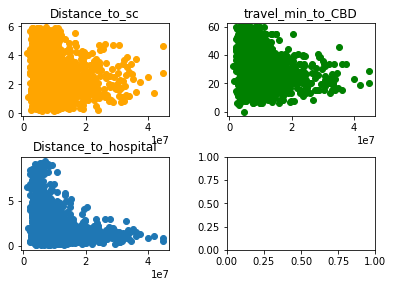

In [31]:
#---------------------- Subplot to show 3 attributes as intructed by business rules  --------------------------------------
combined['price'] = combined['price'].astype(int)
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=2.0)

#---------------------- Scatter plot of attributes  --------------------------------------
axs[0, 0].scatter(combined['price'], combined['Distance_to_sc'], c = 'orange')
axs[0, 0].set_title('Distance_to_sc')
axs[0, 1].scatter(combined['price'], combined['travel_min_to_CBD'], c = 'green')
axs[0, 1].set_title('travel_min_to_CBD')
axs[1, 0].scatter(combined['price'], combined['Distance_to_hospital'])
axs[1, 0].set_title('Distance_to_hospital')

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result</span>
As visually no linear relation can not observed in above graphs, we'll use lmplot to further explot the data  

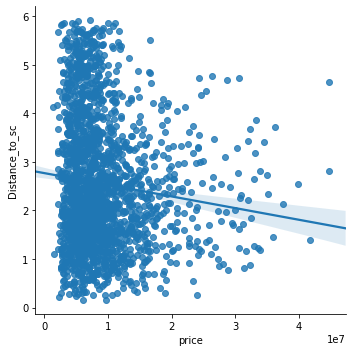

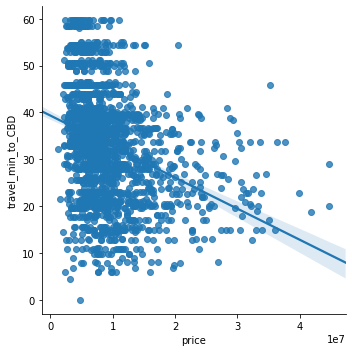

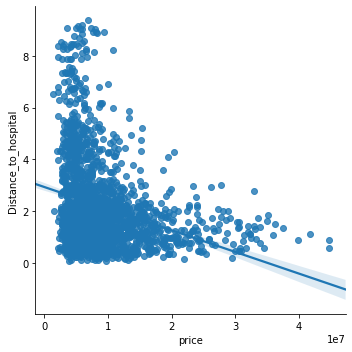

In [32]:
#---------------------- linear model graph to show 3 attributes --------------------------------------
g0 = sns.lmplot(x = "price", y = "Distance_to_sc", data = combined)
g1 = sns.lmplot(x = "price", y = "travel_min_to_CBD", data = combined)
g2 = sns.lmplot(x = "price", y = "Distance_to_hospital", data = combined)

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result</span>
After carefully evaluating scatterplot and lmplot , we can confirm that their may be some form of linear relation between dependent and independent variables. The key in getting an good accuracy and r-sqaure value is transformation of variables. From initial look Distance_to_hospital may require an log transformation. however more experiment is neccesary

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Transformation </span>

In [33]:
combined['new_price'] = combined["price"].apply(lambda x: np.log(x+1))
combined['new_Distance_to_sc'] = combined["Distance_to_sc"].apply(sqrt)
combined['new_travel_min_to_CBD'] = combined["travel_min_to_CBD"].apply(lambda x: np.log(x+1))
combined['new_Distance_to_hospital'] = combined['Distance_to_hospital'].apply(lambda x: np.log(x+1))

###  <span style="font-family: Calibri; font-size:1.0em;color:#000055"> Result</span>
After going through various transformation, above non- linear transformation resulted in best possible accuracy.

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Plotting the transformed graphs </span>

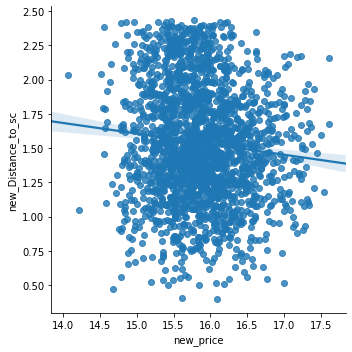

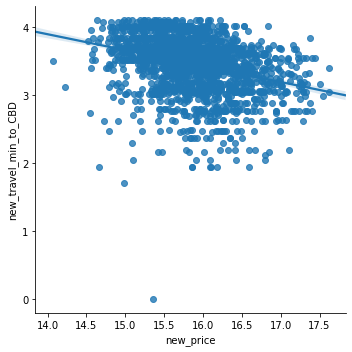

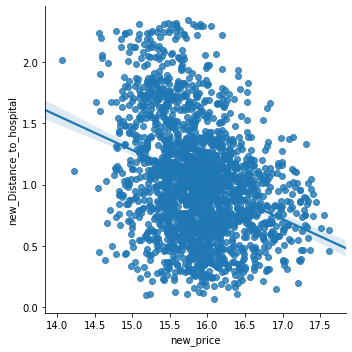

In [34]:
sns.lmplot(x = "new_price", y = "new_Distance_to_sc", data = combined)
sns.lmplot(x = "new_price", y = "new_travel_min_to_CBD", data = combined)
sns.lmplot(x = "new_price", y = "new_Distance_to_hospital", data = combined)

(array([  2.,   6.,  11.,  42.,  56.,  58.,  89.,  87., 104., 117., 103.,
         90.,  99.,  98.,  82.,  85.,  79.,  69.,  55.,  57.,  46.,  64.,
         38.,  34.,  29.,  22.,  24.,  26.,  29.,  15.,  20.,  15.,  20.,
         14.,  15.,  12.,  11.,   9.,   4.,   7.,   9.,  11.,   8.,   6.,
          8.,   4.,   3.,   4.,   2.,   6.,   3.,   5.,   7.,   6.,   2.,
          2.,   2.,   3.,   3.,   0.,   5.,   1.,   2.,   2.,   1.,   2.,
          2.,   5.,   2.,   1.,   3.,   3.,   0.,   4.,   1.,   2.,   1.,
          1.,   1.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([ 1281500.,  1715785.,  2150070.,  2584355.,  3018640.,  3452925.,
         3887210.,  4321495.,  4755780.,  5190065.,  5624350.,  6058635.,
         6492920.,  6927205.,  7361490.,  7795775.,  8230060.,  8664345.,
         9098630.,  9532915.,  9967200., 10401485., 10835770., 11270055.,
        11704340., 121

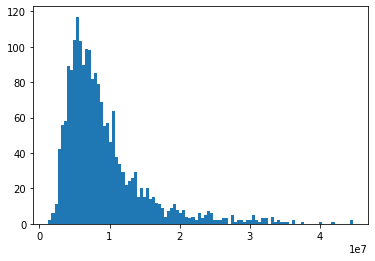

In [35]:
plt.hist(data = combined, x = "price", bins=100)

(array([ 2.,  7.,  9.,  5.,  6., 12., 10., 14., 11., 25., 15., 18., 21.,
        31., 25., 22., 28., 44., 27., 31., 39., 35., 32., 39., 38., 42.,
        41., 30., 33., 49., 36., 51., 40., 24., 39., 28., 36., 23., 34.,
        36., 42., 23., 37., 32., 25., 20., 21., 15., 20., 21., 21., 17.,
        29., 19., 26., 20., 27., 14., 19., 15., 21., 12., 14.,  7., 15.,
        15., 14., 14.,  9., 12., 13., 10., 17., 17., 14.,  6.,  9., 15.,
         8.,  8., 15., 13.,  7., 15., 12.,  7., 10., 11., 11.,  7.,  9.,
        12., 10.,  5.,  6.,  8., 11.,  3.,  4.,  6.]),
 array([0.159  , 0.21657, 0.27414, 0.33171, 0.38928, 0.44685, 0.50442,
        0.56199, 0.61956, 0.67713, 0.7347 , 0.79227, 0.84984, 0.90741,
        0.96498, 1.02255, 1.08012, 1.13769, 1.19526, 1.25283, 1.3104 ,
        1.36797, 1.42554, 1.48311, 1.54068, 1.59825, 1.65582, 1.71339,
        1.77096, 1.82853, 1.8861 , 1.94367, 2.00124, 2.05881, 2.11638,
        2.17395, 2.23152, 2.28909, 2.34666, 2.40423, 2.4618 , 2.51937,
        

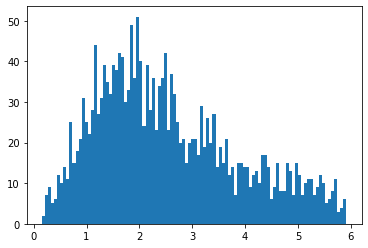

In [36]:
plt.hist(data = combined, x = "Distance_to_sc", bins=100)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  7.,  5.,  1.,
        12.,  0.,  3., 10.,  2., 19.,  0.,  0., 25.,  0., 12., 20., 22.,
        26.,  0., 22., 12., 16., 15., 28., 48., 50., 22., 34., 19., 46.,
        10., 16., 14., 15., 49., 11., 20., 60., 26., 46.,  6., 26., 41.,
         9., 55., 24., 76., 74.,  0., 49., 30., 38., 96.,  0., 41., 27.,
        56., 91., 24., 18., 16.,  5., 17.,  7., 46.,  9.,  0., 92., 24.,
         0.,  0.,  0., 11.,  0., 22., 42.,  6.,  0.,  0., 25.,  3., 28.,
        47., 10.,  0.,  0.,  0.,  0.,  1., 24., 22.]),
 array([ 0.        ,  0.59666667,  1.19333333,  1.79      ,  2.38666667,
         2.98333333,  3.58      ,  4.17666667,  4.77333333,  5.37      ,
         5.96666667,  6.56333333,  7.16      ,  7.75666667,  8.35333333,
         8.95      ,  9.54666667, 10.14333333, 10.74      , 11.33666667,
        11.93333333, 12.53      , 13.12666667, 13.72333333, 14.32      ,
        14.91666667, 15.51333333, 16.11      , 16.70666667, 17.303333

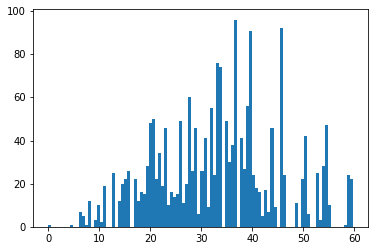

In [37]:
plt.hist(data = combined, x = "travel_min_to_CBD", bins=100)

(array([ 8., 20., 36., 59., 54., 55., 56., 65., 69., 79., 65., 70., 65.,
        60., 72., 61., 59., 67., 52., 62., 59., 63., 53., 43., 41., 28.,
        35., 30., 17., 32., 21., 30.,  7., 15.,  8., 15., 10., 16., 13.,
        11., 11.,  6., 11., 13., 14., 14.,  9., 13., 16., 17., 12.,  6.,
        10.,  6.,  7., 12.,  9.,  6.,  5.,  3.,  3.,  1.,  3.,  4.,  1.,
         6.,  2.,  3.,  2.,  2.,  4.,  6.,  3.,  2.,  4.,  0.,  3.,  2.,
         6.,  0.,  2.,  0.,  0.,  2.,  5.,  1.,  1.,  3.,  4.,  4.,  6.,
         1.,  1.,  1.,  2.,  3.,  6.,  1.,  1.,  1.]),
 array([0.07   , 0.16294, 0.25588, 0.34882, 0.44176, 0.5347 , 0.62764,
        0.72058, 0.81352, 0.90646, 0.9994 , 1.09234, 1.18528, 1.27822,
        1.37116, 1.4641 , 1.55704, 1.64998, 1.74292, 1.83586, 1.9288 ,
        2.02174, 2.11468, 2.20762, 2.30056, 2.3935 , 2.48644, 2.57938,
        2.67232, 2.76526, 2.8582 , 2.95114, 3.04408, 3.13702, 3.22996,
        3.3229 , 3.41584, 3.50878, 3.60172, 3.69466, 3.7876 , 3.88054,
        

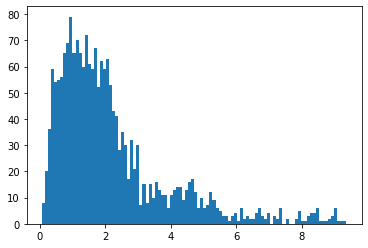

In [38]:
plt.hist(data = combined, x = "Distance_to_hospital", bins=100)

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         3.,  3.,  2.,  3.,  2.,  2.,  2.,  8.,  9., 12., 12.,  9., 20.,
        10., 18., 14., 24., 16., 25., 31., 32., 24., 31., 36., 34., 53.,
        51., 51., 50., 45., 49., 49., 50., 53., 63., 56., 44., 60., 53.,
        55., 55., 46., 51., 33., 43., 44., 49., 37., 36., 33., 21., 28.,
        23., 34., 16., 23., 23., 20., 21., 14., 14.,  7., 14., 15., 12.,
        10.,  6.,  7.,  7., 13.,  5.,  4.,  6.,  6.,  4.,  5.,  8.,  5.,
         6.,  3.,  3.,  1.,  1.,  1.,  0.,  1.,  2.]),
 array([14.06354261, 14.09906426, 14.13458591, 14.17010756, 14.20562921,
        14.24115086, 14.27667252, 14.31219417, 14.34771582, 14.38323747,
        14.41875912, 14.45428077, 14.48980242, 14.52532408, 14.56084573,
        14.59636738, 14.63188903, 14.66741068, 14.70293233, 14.73845399,
        14.77397564, 14.80949729, 14.84501894, 14.88054059, 14.91606224,
        14.9515839 , 14.98710555, 15.0226272 , 15.05814885, 15.093670

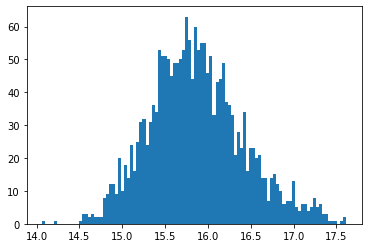

In [39]:
plt.hist(data = combined, x = "new_price", bins=100)

(array([ 2.,  0.,  0.,  1.,  2.,  3.,  3.,  6.,  1.,  1.,  4.,  3.,  1.,
         6.,  6.,  4.,  7.,  8.,  6.,  7.,  7., 15., 10., 10., 11., 14.,
        15., 20., 17., 18., 17., 20., 17., 35., 27., 26., 27., 26., 31.,
        29., 26., 36., 39., 34., 41., 28., 31., 44., 39., 47., 41., 27.,
        36., 32., 35., 36., 32., 44., 33., 38., 40., 26., 23., 26., 18.,
        28., 23., 25., 34., 31., 25., 30., 21., 27., 21., 17.,  9., 26.,
        17., 19., 16., 16., 22., 24., 14., 15., 18., 15., 20., 15., 20.,
        15., 17., 13., 18., 16.,  9., 17.,  6.,  9.]),
 array([0.39874804, 0.41908339, 0.43941874, 0.45975409, 0.48008943,
        0.50042478, 0.52076013, 0.54109548, 0.56143083, 0.58176618,
        0.60210152, 0.62243687, 0.64277222, 0.66310757, 0.68344292,
        0.70377827, 0.72411361, 0.74444896, 0.76478431, 0.78511966,
        0.80545501, 0.82579036, 0.84612571, 0.86646105, 0.8867964 ,
        0.90713175, 0.9274671 , 0.94780245, 0.9681378 , 0.98847314,
        1.00880849, 1.0291

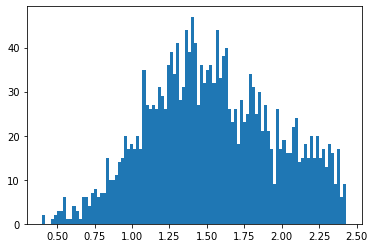

In [40]:
plt.hist(data = combined, x = "new_Distance_to_sc", bins=100)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   7.,   0.,   5.,   0.,   1.,   5.,   7.,   0.,
          0.,   3.,  10.,   0.,   2.,  19.,   0.,   0.,  18.,   7.,   4.,
         14.,  36.,  22.,   4.,  22.,  28.,  15.,  34.,  74.,  65.,  28.,
         56.,  16.,  44.,  45.,  63.,  89.,  47.,  42., 148.,  74., 108.,
        105., 124., 133.,  21.,  79., 106.,  10.,  33.,  48., 103.,  10.,
         47.]),
 array([0.        , 0.04105394, 0.08210789, 0.12316183, 0.16421578,
        0.20526972, 0.24632366, 0.28737761, 0.32843155, 0.3694855 ,
        0.41053944, 0.45159338, 0.49264733, 0.53370127, 0.57475522,
        0.61580916, 0.6568631 , 0.69791705, 0.73897099, 0.78002494,
        0.82107888, 0.86213282, 0.90318677, 0.

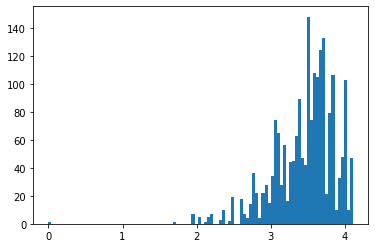

In [41]:
plt.hist(data = combined, x = "new_travel_min_to_CBD", bins=100)

(array([ 1.,  4.,  3.,  2.,  4.,  5.,  9.,  9., 11., 12., 24., 12., 22.,
        18., 21., 20., 17., 29., 28., 20., 22., 25., 31., 28., 26., 36.,
        41., 36., 29., 39., 44., 28., 37., 34., 33., 47., 33., 44., 39.,
        31., 48., 38., 35., 41., 46., 41., 48., 46., 31., 40., 29., 24.,
        26., 25., 23., 25., 22., 28., 20., 11., 11.,  9., 16., 18., 12.,
        14., 11.,  9., 14., 20., 17., 14., 20., 21., 14., 14.,  9., 14.,
        13.,  8.,  4.,  3.,  6.,  7.,  4.,  4.,  7.,  8.,  5.,  3.,  8.,
         2.,  0.,  8.,  4., 11.,  4.,  4.,  9.,  3.]),
 array([0.06765865, 0.09036544, 0.11307224, 0.13577904, 0.15848583,
        0.18119263, 0.20389943, 0.22660622, 0.24931302, 0.27201981,
        0.29472661, 0.31743341, 0.3401402 , 0.362847  , 0.38555379,
        0.40826059, 0.43096739, 0.45367418, 0.47638098, 0.49908778,
        0.52179457, 0.54450137, 0.56720816, 0.58991496, 0.61262176,
        0.63532855, 0.65803535, 0.68074214, 0.70344894, 0.72615574,
        0.74886253, 0.7715

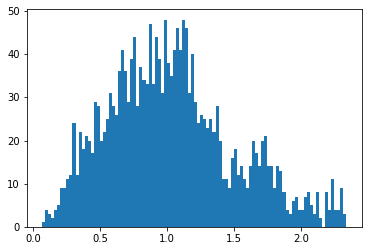

In [42]:
plt.hist(data = combined, x = "new_Distance_to_hospital", bins=100)

###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Linear Modelling </span>

In [43]:
#---------------------- linear model graph to show 3 attributes --------------------------------------
datavsprice = sm.ols(formula="price ~ Distance_to_hospital+travel_min_to_CBD+Distance_to_sc", data=combined).fit()

#---------------------- model accuracy and r-square --------------------------------------
print(datavsprice.rsquared, datavsprice.rsquared_adj)

0.136268235413339 0.13495888963579483


In [44]:
standard_scale = preprocessing.StandardScaler().fit(combined[['price', 'Distance_to_hospital','travel_min_to_CBD','Distance_to_sc']])

col_int = combined[['price', 'Distance_to_hospital','travel_min_to_CBD','Distance_to_sc']]

arr_standard = standard_scale.transform(combined[['price', 'Distance_to_hospital','travel_min_to_CBD','Distance_to_sc']]) # an array not a df
features = pd.DataFrame(arr_standard, index=col_int.index, columns=col_int .columns)

features.head()

,price,Distance_to_hospital,travel_min_to_CBD,Distance_to_sc
0,-0.533692,-0.370627,-0.981816,-0.933662
1,-0.075486,-0.557128,0.046261,-0.517321
2,-1.005970,-0.853912,-1.149640,-0.086083
3,0.040352,0.568805,1.778889,0.133632
4,0.434203,-1.151851,0.469862,-0.288668


###  <span style="font-family: Calibri; font-size:1.2em;color:#000055"> Result </span>
After exploring normalization and linearity graph (z-standard transform) are acceptable for transformed data and their may not be any need to perform standard scaler transformation. Therefore concluding that applying above transformation to linear model is acceptable will be accurate